In [ ]:
import requests
import json
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')

# Fetch FED Funds Rate (FRED) using FRED Public API

In [ ]:
# Import or assign API key
api_key = "58394c9866a5e8ff6f27cbd23af8e6f7"

# Define the FRED API endpoint
base_url = 'https://api.stlouisfed.org/fred/'

'''
Get observation data from the FRED API
'''

# Assign endpoint
obs_endpoint = 'series/observations'

# Assign parameters
series_id = 'FEDFUNDS'
start_date = '1999-01-01'
end_date = '2024-01-31'
#ts_frequency = 'm'
#ts_units = 'pc1'

obs_params = {
    'series_id': series_id,
    'api_key': api_key,
    'file_type': 'json',
    'observation_start': start_date,
    'observation_end': end_date,
    # 'frequency': ts_frequency
    # 'units': ts_units
}

# Make request to FRED API
response = requests.get(base_url + obs_endpoint, params=obs_params)

# Format data
if response.status_code == 200:
    res_data = response.json()
    obs_data = pd.DataFrame(res_data['observations'])
    obs_data['date'] = pd.to_datetime(obs_data['date'])
    #obs_data.set_index('date', inplace=True)
    obs_data['FUND RATE'] = obs_data['value'].astype(float)
    obs_data = obs_data.drop(columns=["realtime_start", "realtime_end","value"])

else:
    print('Failed to retrieve data. Status code:', response.status_code)

In [ ]:
obs_data = obs_data.drop_duplicates(subset=['date'], keep="last").reset_index(drop=True)
obs_data.head()

,date,FUND RATE
0,1999-01-01,4.63
1,1999-02-01,4.76
2,1999-03-01,4.81
3,1999-04-01,4.74
4,1999-05-01,4.74


In [ ]:
obs_data.sort_values(by='date',inplace=True)

In [ ]:
df_intr = obs_data.set_index('date')

In [ ]:
df_intr.head(), df_intr.shape

(            FUND RATE
 date                 
 1999-01-01       4.63
 1999-02-01       4.76
 1999-03-01       4.81
 1999-04-01       4.74
 1999-05-01       4.74,
 (301, 1))

In [ ]:
#Export  Interest rate Dataset to google drive
# path = '/content/drive/MyDrive/DATA 698/Data Science Project/timeseries_Interest.csv'
# with open(path, 'w', encoding = 'utf-8-sig') as f:
#   df_intr.to_csv(f)


# Exponential Smoothing

In [ ]:
# Import packages
from sklearn.model_selection import TimeSeriesSplit
import numpy as np
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import plotly.express as px

In [ ]:
def hyperparameter_tuning_season_cv(n_splits: int,var,
                                    gammas: list[float],
                                    df: pd.DataFrame) -> pd.DataFrame:
    """Function to carry out cross-validation hyperparameter tuning
    for the seasonal parameter in a Holt Winters' model. """

    tscv = TimeSeriesSplit(n_splits=n_splits)
    error_list = []
    forecast_list = []
    gamma_list  = []

    for gamma in gammas:

        errors = []

        for train_index, valid_index in tscv.split(df):
            train, valid = df.iloc[train_index], df.iloc[valid_index]

            model = ExponentialSmoothing(train[var], trend='mul',
                                         seasonal='mul', seasonal_periods=12).fit(smoothing_seasonal=gamma)

            forecasts = model.forecast(len(valid))
            errors.append(mean_absolute_percentage_error(valid[var], forecasts))

        error_list.append([gamma, sum(errors) / len(errors)])
        forecast_list.append(forecasts) #added
        gamma_list.append(gamma) #added

    return pd.DataFrame(error_list, columns=['Gamma', 'MAPE'])


def plot_error_cv(df: pd.DataFrame,title: str) -> None:
    """Bar chart to plot the errors from the different
    hyperparameters."""

    fig = px.bar(df, x='Gamma', y='MAPE')
    fig.update_layout(template="simple_white", font=dict(size=18), title_text=title,
                      width=800, title_x=0.5, height=400)
    df_smooth = df[df.MAPE==df.MAPE.min()]
    smooth_factor = df_smooth.Gamma
    print('Smoothing Factor: ',smooth_factor)

    return fig.show(),smooth_factor

#Predict Unemployment Rate

In [ ]:
# Carry out cv for hyperparameter tuning for the seasonal parameter
error_df = hyperparameter_tuning_season_cv(df=df_intr,n_splits=4,var='FUND RATE',gammas=list(np.arange(0, 1.1, 0.1)))

# Plot the tuning results to view the best smoothing constant
plot,smooth = plot_error_cv(df=error_df, title='Hyperparameter Results')

#Build an Exponential model with the best smoothing constant
model2 = ExponentialSmoothing(df_intr['FUND RATE'], trend='mul',seasonal='mul', seasonal_periods=12).fit(smoothing_seasonal=smooth)

Smoothing Factor:  8    0.8
Name: Gamma, dtype: float64


In [ ]:
  # Split train and test
train = df_intr.iloc[:-12]
print('Train size: ', len(train))
test = df_intr.iloc[-12:]
print('Test size: ',len(test))

Train size:  289
Test size:  12


In [ ]:
col = ['FUND RATE']
model = ExponentialSmoothing(train['FUND RATE'], trend='mul',seasonal='mul', seasonal_periods=12).fit(smoothing_seasonal=smooth)
predictions = model.forecast(steps=len(test))
pred =  pd.DataFrame(predictions).set_index(test.index)
pred.columns = col
residuals = test['FUND RATE'] - pred['FUND RATE']
print(pred)

            FUND RATE
date                 
2023-02-01   4.558872
2023-03-01  10.506650
2023-04-01   8.254581
2023-05-01   9.102861
2023-06-01   4.633637
2023-07-01   7.499970
2023-08-01  10.980328
2023-09-01   7.598140
2023-10-01   7.095477
2023-11-01   6.985575
2023-12-01   6.468280
2024-01-01   5.983645


Text(0, 0.5, 'Error')

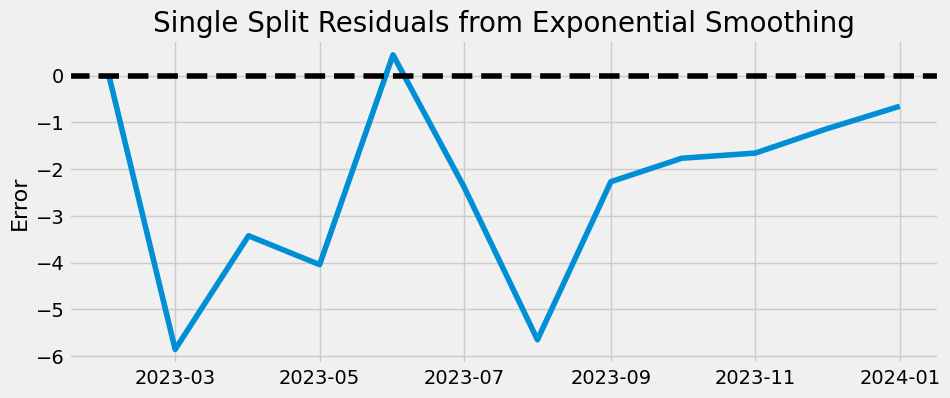

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Single Split Residuals from Exponential Smoothing', fontsize=20)
plt.ylabel('Error', fontsize=16)

Text(0.5, 1.0, 'INTEREST RATE')

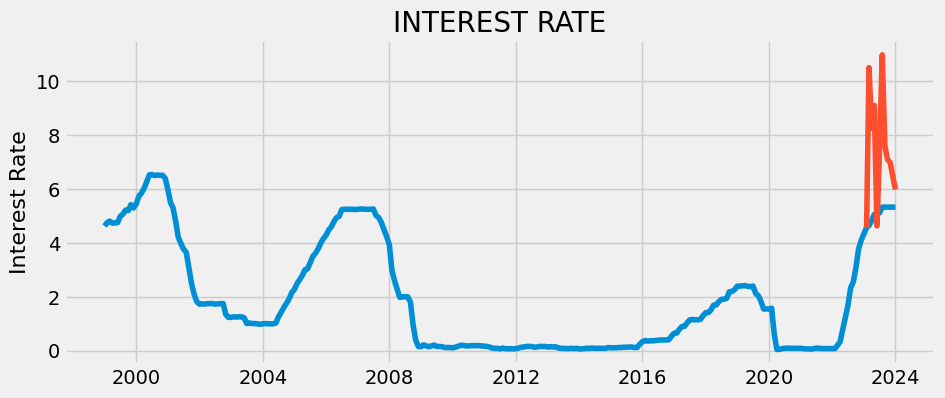

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(df_intr)
plt.plot(pred)
plt.ylabel('Interest Rate', fontsize=16)
plt.title('INTEREST RATE', fontsize=20)

In [ ]:
print('Mean Absolute Percent Error:', round(np.mean(abs(residuals/test['FUND RATE']*100)),4))

Mean Absolute Percent Error: 48.2194


In [ ]:
print('Root Mean Squared Error:', np.sqrt(np.mean(residuals**2)))

Root Mean Squared Error: 3.06713604336348


# Rolling Forecast Origin

In [ ]:
rolling_predictions = test.copy()
pred_list = []
for train_end in test.index:
  train_data = df_intr[:train_end-timedelta(days=1)]
  model = ExponentialSmoothing(train_data['FUND RATE'], trend='mul',seasonal='mul', seasonal_periods=12).fit(smoothing_seasonal=smooth)
  pred = model.forecast()
  pred_list.append(pred.values)
print(pred)
prediction = pd.DataFrame(pred_list)

2024-01-01    4.82299
Freq: MS, dtype: float64


In [ ]:
test_date = pd.date_range('2023-04-01', '2024-03-01', freq='MS')

In [ ]:
col2 = ['pred_var']
prediction.columns = col2
prediction.set_index(test.index,inplace=True)

In [ ]:
rolling_residuals = test['FUND RATE'] - prediction['pred_var']

In [ ]:
prediction.sort_values(by='date',inplace=True)

Text(0, 0.5, 'Error')

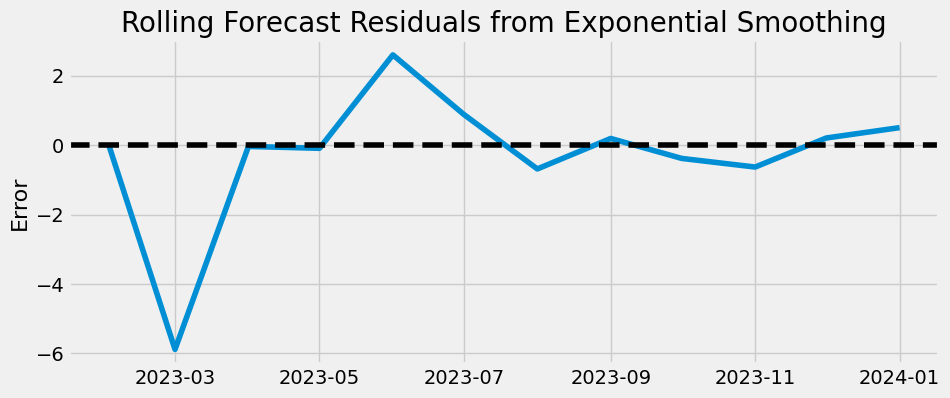

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(rolling_residuals)
plt.axhline(0, linestyle='--', color='k')
plt.title('Rolling Forecast Residuals from Exponential Smoothing', fontsize=20)
plt.ylabel('Error', fontsize=16)

In [ ]:
start_date = datetime(2023,4,1)
end_date = datetime(2024,3,1)

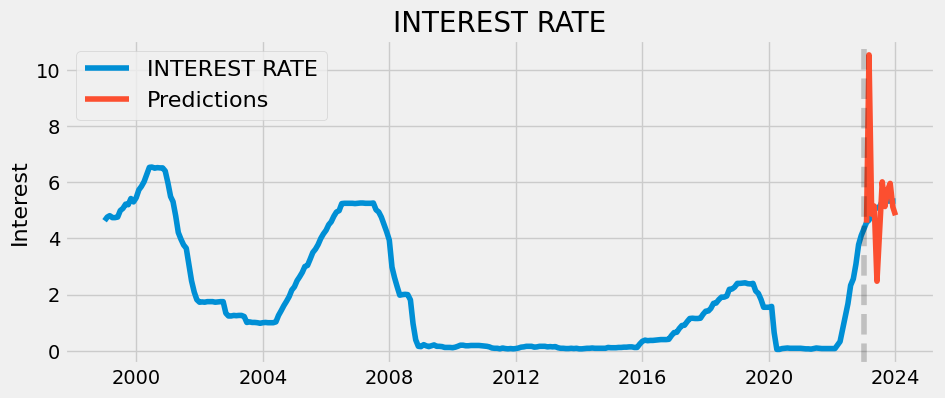

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(df_intr)
plt.plot(prediction['pred_var'])
plt.legend(('INTEREST RATE', 'Predictions'), fontsize=16)
plt.title('INTEREST RATE', fontsize=20)
plt.ylabel('Interest', fontsize=16)
for year in range(start_date.year,end_date.year):
  plt.axvline(pd.to_datetime(str(year)+'-01-01'), color='k', linestyle='--', alpha=0.2)

In [ ]:
print('Mean Absolute Percent Error:', round(np.mean(abs(rolling_residuals/test['FUND RATE']*100)),4))

Mean Absolute Percent Error: 20.5493


In [ ]:
print('Root Mean Squared Error:', np.sqrt(np.mean(rolling_residuals**2)))

Root Mean Squared Error: 1.9044290944399092


# Forcasting the future

In [ ]:
#Build an Exponential model with the best smoothing constant
model2 = ExponentialSmoothing(df_intr['FUND RATE'], trend='mul',seasonal='mul', seasonal_periods=12).fit(smoothing_seasonal=smooth)

In [ ]:
# Six (6) months future projection
future1 = pd.date_range('2024-02-01','2024-12-31', freq='MS')
col = ['FUND RATE']

In [ ]:
df_intr['FUND RATE'].tail()

date
2023-09-01    5.33
2023-10-01    5.33
2023-11-01    5.33
2023-12-01    5.33
2024-01-01    5.33
Name: FUND RATE, dtype: float64

In [ ]:
predictions = model2.forecast(steps=11)
pred =  pd.DataFrame(predictions).set_index(future1)
pred.columns = col

In [ ]:
pred

,FUND RATE
2024-02-01,4.788286
2024-03-01,5.282695
2024-04-01,6.447547
2024-05-01,6.804912
2024-06-01,6.188965
2024-07-01,4.173253
2024-08-01,4.095282
2024-09-01,4.205707
2024-10-01,4.200886
2024-11-01,4.411933


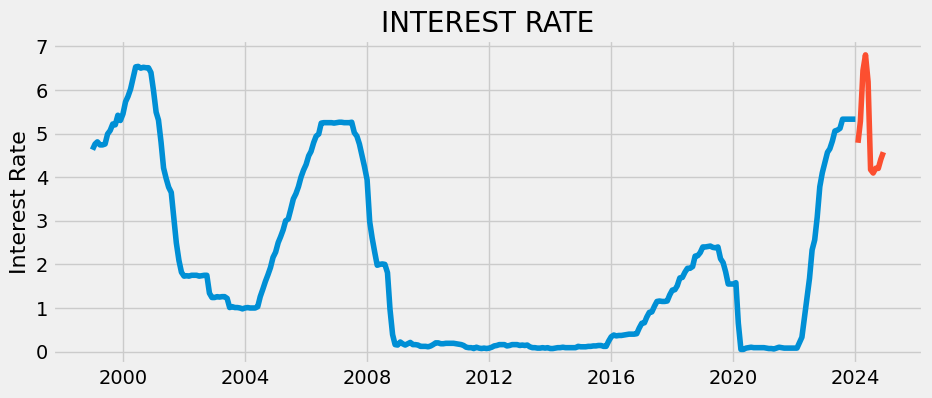

In [ ]:
plt.figure(figsize=(10,4))
plt.plot(df_intr)
plt.plot(pred)
plt.ylabel('Interest Rate', fontsize=16)
plt.title('INTEREST RATE', fontsize=20)
plt.show()